In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from custom_causal_inference import CustomCausalInference
import utils
import forward_models_causal_inference
import matplotlib.pyplot as plt
import pickle

c:\Users\Ana\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%reload_ext autoreload

In [3]:
D = 250  # grid dimension 
angle_gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='./uniform_model_base_inv_kappa_free.pkl'
p_commons = np.linspace(0, 1, num=20)

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

In [4]:
# optimal_kappa_pairs_filepath = './learned_data/optimal_kappa_pairs_10by10.pkl'
# min_error_for_idx_pc_filepath = './learned_data/min_error_for_idx_pc_10by10.pkl'
# min_error_for_idx_filepath = './learned_data/min_error_for_idx_10by10.pkl'
# s_ns_filepath = './learned_data/selected_s_n_10by10.npy'
# ts_filepath = './learned_data/selected_t_10by10.npy'
# r_ns_filepath = './learned_data/selected_r_n_10by10.npy'
# optimal_kappa_pairs_filepath = './learned_data/optimal_kappa_pairs_10by10.pkl'
# min_error_for_idx_pc_filepath = './learned_data/min_error_for_idx_pc_10by10.pkl'
# min_error_for_idx_filepath = './learned_data/min_error_for_idx_10by10.pkl'
optimal_kappa_pairs_filepath = './learned_data/optimal_kappa_pairs_4.pkl'
min_error_for_idx_pc_filepath = './learned_data/min_error_for_idx_pc_4.pkl'
min_error_for_idx_filepath = './learned_data/min_error_for_idx_4.pkl'
s_ns_filepath = './learned_data/selected_s_n.npy'
ts_filepath = './learned_data/selected_t.npy'
r_ns_filepath = './learned_data/selected_r_n.npy'

In [5]:
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)

In [6]:
grid_dim = int(np.sqrt(s_ns.shape[0]))
grid_dim

5

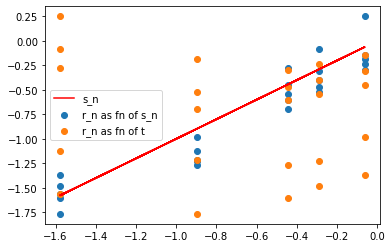

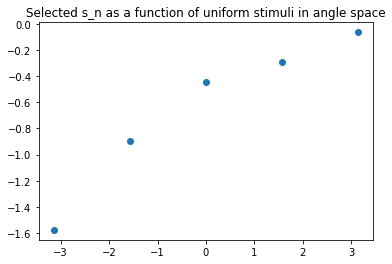

In [7]:
plt.scatter(s_ns, r_ns, label = 'r_n as fn of s_n')
plt.scatter(ts, r_ns, label='r_n as fn of t')
plt.plot(s_ns, s_ns, label='s_n', c='r')
plt.legend()
plt.show()
plt.scatter(np.linspace(-np.pi, np.pi, num=grid_dim), s_ns[:grid_dim])
plt.title('Selected s_n as a function of uniform stimuli in angle space')
plt.show()

In [9]:
err_mat = np.zeros_like(s_ns)
optimal_kappa_pairs_arr = np.zeros((*s_ns.shape, 2))
optimal_pc = np.zeros_like(s_ns)
for key in min_error_for_idx_pc:
    if min_error_for_idx_pc[key] == min_error_for_idx[key[0]]:
        optimal_pc[key[0]] = key[1]
        err_mat[int(key[0])] = min_error_for_idx[key[0]]
        optimal_kappa_pairs_arr[int(key[0]), :] = np.array(optimal_kappa_pairs[key]).reshape(2,)
        print(f'{key[0]}: t, s_n, r_n = {np.round(s_ns[key[0]], 3), np.round(ts[key[0]], 3), np.round(r_ns[key[0]], 4)}', 
              f'd/pi={np.round(utils.circular_dist(s_ns[key[0]], ts[key[0]]) / np.pi, 4)}', 
              f'min_err={min_error_for_idx_pc[key]}',  
              f'p_c={np.round(key[1], 3)}', 
              f'optimal_kappa={optimal_kappa_pairs[key]}')

0: t, s_n, r_n = (-1.577, -1.577, -1.5644) d/pi=0.0 min_err=4.822742367593946e-05 p_c=0.947 optimal_kappa=(array([2.41827118]), array([117.80575125]))
1: t, s_n, r_n = (-0.896, -1.577, -1.1233) d/pi=0.2169 min_err=0.0011293751673182584 p_c=0.737 optimal_kappa=(array([82.70371084]), array([18.16590212]))
2: t, s_n, r_n = (-0.442, -1.577, -0.2768) d/pi=0.3614 min_err=0.0167170910595682 p_c=0.0 optimal_kappa=(array([82.70371084]), array([300.]))
3: t, s_n, r_n = (-0.29, -1.577, -0.0779) d/pi=0.4096 min_err=0.1055747316856186 p_c=0.0 optimal_kappa=(array([1.]), array([1.1]))
4: t, s_n, r_n = (-0.063, -1.577, 0.2519) d/pi=0.4819 min_err=0.23417582550773286 p_c=0.158 optimal_kappa=(array([1.]), array([1.1]))
5: t, s_n, r_n = (-1.577, -0.896, -1.7664) d/pi=0.2169 min_err=0.026201907763931942 p_c=0.0 optimal_kappa=(array([34.19951893]), array([7.13349249]))
6: t, s_n, r_n = (-0.896, -0.896, -1.2201) d/pi=0.0 min_err=0.05361399422258195 p_c=0.0 optimal_kappa=(array([5.84803548]), array([1.1]))


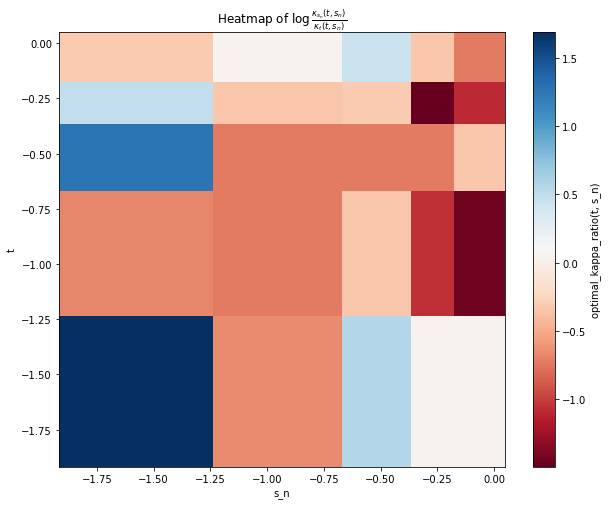

In [10]:
optimal_kappa_ratio = optimal_kappa_pairs_arr[:, 1] / optimal_kappa_pairs_arr[:, 0]
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               np.log10(optimal_kappa_ratio.reshape((grid_dim, grid_dim))), shading='auto', cmap='RdBu')
plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of $\log{\\frac{\kappa_{s_n}(t, s_n)}{\kappa_{t}(t, s_n)}}$')
plt.show()

In [13]:
optimal_kappa_pairs_arr[optimal_kappa_pairs_arr[:, 0] <= optimal_kappa_pairs_arr[:, 1]]

array([[  2.41827118, 117.80575125],
       [ 82.70371084, 300.        ],
       [  1.        ,   1.1       ],
       [  1.        ,   1.1       ],
       [  1.        ,  18.16590212],
       [  5.84803548,  18.16590212],
       [  1.        ,   1.1       ],
       [  1.        ,   2.80122147]])

In [14]:
s_ns.reshape((grid_dim,grid_dim))[0], ts.reshape((grid_dim,grid_dim))[0]

(array([-1.57710475, -0.8957955 , -0.44158933, -0.29018727, -0.06308419]),
 array([-1.57710475, -1.57710475, -1.57710475, -1.57710475, -1.57710475]))

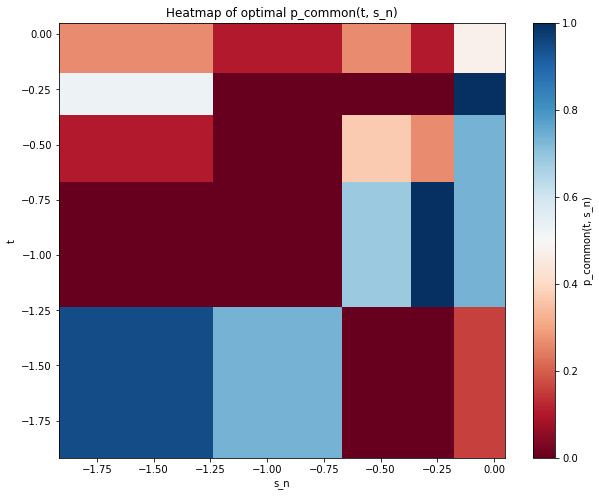

In [15]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               optimal_pc.reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
plt.colorbar(label='p_common(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of optimal p_common(t, s_n)')
plt.show()

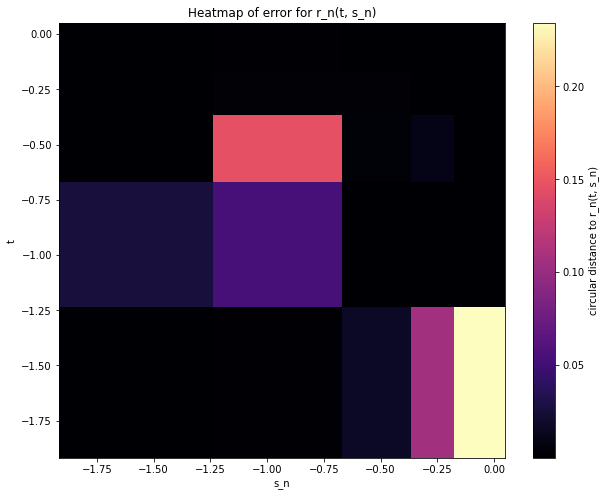

In [16]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               err_mat.reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
plt.colorbar(label='circular distance to r_n(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of error for r_n(t, s_n)')
plt.show()

## Looking at optimal $\kappa$ pairs

In [20]:
dicts = []
lens = []
num_tasks = 500

with open (f'./learned_data/task_metadata.pkl', 'rb') as f:
    tasks_metadata = pickle.load(f)

for i in range(num_tasks):
    with open (f'./learned_data/optimal_kappa_errors/errors_dict_{i}.pkl', 'rb') as f:
        errors_dict = pickle.load(f)
    dicts.append(errors_dict)
    lens.append(errors_dict['errors'].shape)
print('Number of values saved per task', lens)

Number of values saved per task [(20,), (29,), (28,), (50,), (26,), (22,), (25,), (26,), (28,), (28,), (22,), (26,), (27,), (25,), (28,), (28,), (30,), (26,), (31,), (32,), (49,), (49,), (49,), (49,), (2,), (3,), (2,), (49,), (5,), (4,), (7,), (2,), (3,), (8,), (8,), (2,), (2,), (2,), (49,), (4,), (18,), (18,), (18,), (17,), (17,), (17,), (16,), (16,), (17,), (16,), (15,), (15,), (16,), (15,), (16,), (15,), (16,), (14,), (15,), (8,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (50,), (49,), (49,), (49,), (49,), (49,), (49,), (2,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49,), (49

In [21]:
task_idxs =  [3, 93, 203]
for task_idx in task_idxs:
    print(f'Otimal kappas for the {task_idx}-th task:{dicts[task_idx]["optimal_kappa1"], dicts[task_idx]["optimal_kappa2"]}')
    print(f'Task {task_idx} metadata: {tasks_metadata[task_idx]}')
    mean_indices = tasks_metadata[task_idx]["mean_indices"]
    print(f'Selected values: s_n t, r_n: {s_ns[mean_indices], ts[mean_indices], r_ns[mean_indices]}')
    print(f'Optimal kappa pairs from dict: {optimal_kappa_pairs[(tasks_metadata[task_idx]["mean_indices"][0], tasks_metadata[task_idx]["p_common"])]} ')

Otimal kappas for the 3-th task:(array([  5.3289,   1.3216,  16.258 ,  49.6016,   1.7467,  12.3016,
       114.5029,   2.3085, 200.    ,  16.258 ,  28.3976,  12.3016,
         1.3216, 151.3293,   9.308 ,  21.487 ,  21.487 ,  21.487 ,
        49.6016,  12.3016, 200.    ,  21.487 , 200.    ,   4.0321,
        65.5545, 114.5029,   7.0428,   7.0428,  65.5545, 200.    ,
         1.3216,  37.5309,  28.3976,   1.3216,   2.3085,   2.3085,
        12.3016,  37.5309,  65.5545,  16.258 ,   1.    ,   1.    ,
        16.258 ,  28.3976,   7.0428,   9.308 ,   5.3289,  16.258 ,
         7.0428,  65.5545]), array([166.2374, 166.2374,   4.8125, 123.7464,  92.1163,  92.1163,
         8.6849, 123.7464,  15.6732,   1.1   ,  37.9968,  51.0439,
        28.2847, 223.3187,  15.6732,  37.9968,  92.1163, 300.    ,
        28.2847,  15.6732,   8.6849, 223.3187,   6.465 , 300.    ,
        21.055 ,  92.1163, 300.    ,  92.1163, 166.2374, 223.3187,
        68.5709, 300.    ,  68.5709,  92.1163, 166.2374,  21.055 ,
